# Training machine learning models on pairs of substrates in individual organisms

## Imports

In [1]:
from subpred.util import load_df
from subpred.graph import preprocess_data, get_substrate_matrix
from subpred.pssm import calculate_pssm_feature
from subpred.compositions import calculate_aac, calculate_paac
import pandas as pd
from subpred.cdhit import cd_hit
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import matplotlib.pyplot as plt
import seaborn as sns
from subpred.custom_transformers import FeatureCombinator, get_feature_type_combinations

from subpred.util import load_df
import networkx as nx


## Functions

### Dataset

In [2]:
def get_classification_task(
    organism_ids: set,
    labels: set,
    clustering_threshold: int = None,
    dataset_folder_path: str = "../data/datasets",
    include_ancestor_chebi_ids: bool = False,
) -> pd.DataFrame:
    (
        df_uniprot,
        df_uniprot_goa,
        graph_go_filtered,
        graph_chebi_filtered,
    ) = preprocess_data(
        organism_ids=organism_ids, datasets_folder_path=dataset_folder_path
    )
    df_substrate_overlaps, dict_chebi_to_uniprot = get_substrate_matrix(
        datasets_folder_path=dataset_folder_path,
        graph_chebi=graph_chebi_filtered,
        graph_go=graph_go_filtered,
        df_uniprot_goa=df_uniprot_goa,
        min_overlap=0,
        max_overlap=int(1e6),
        include_ancestor_chebi_ids=include_ancestor_chebi_ids,
    )
    assert df_substrate_overlaps.shape[0] == len(dict_chebi_to_uniprot.keys())
    chebi_name_to_term = {
        name: term for term, name in graph_chebi_filtered.nodes(data="name")
    }
    chebi_term_to_name = {
        term: name for term, name in graph_chebi_filtered.nodes(data="name")
    }
    molecule_counts = {
        chebi_term_to_name[term]: len(proteins)
        for term, proteins in dict_chebi_to_uniprot.items()
    }
    # print(sorted(molecule_counts.items(), key=lambda item: item[1], reverse=True))

    protein_to_label = list()
    for label in labels:
        label_proteins = dict_chebi_to_uniprot[chebi_name_to_term[label]]
        for protein in label_proteins:
            protein_to_label.append([protein, label])

    df_labels = pd.DataFrame.from_records(
        protein_to_label, columns=["Uniprot", "label"], index="Uniprot"
    )
    df_labels = df_labels[df_labels.index.isin(df_uniprot.index)]

    df_labels = df_labels[~df_labels.index.duplicated()]  # TODO series?
    df_sequences = df_uniprot.loc[df_labels.index].sequence.to_frame()
    if clustering_threshold:
        cluster_representatives = cd_hit(
            df_sequences.sequence, identity_threshold=clustering_threshold
        )
        df_sequences = df_sequences.loc[cluster_representatives]
        df_labels = df_labels.loc[cluster_representatives]
    return pd.concat([df_sequences, df_labels], axis=1)


### Features

In [3]:
def get_features(series_sequences: pd.Series):
    df_aac = calculate_aac(series_sequences)
    df_paac = calculate_paac(series_sequences)
    df_pssm_50_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder="../data/intermediate/blast/pssm_uniref50_1it",
        blast_db="../data/raw/uniref/uniref50/uniref50.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbose=False,
        feature_name="PSSM_50_1",
    )
    df_pssm_50_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder="../data/intermediate/blast/pssm_uniref50_3it",
        blast_db="../data/raw/uniref/uniref50/uniref50.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbose=False,
        feature_name="PSSM_50_3",
    )
    df_pssm_90_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder="../data/intermediate/blast/pssm_uniref90_3it",
        blast_db="../data/raw/uniref/uniref90/uniref90.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbose=False,
        feature_name="PSSM_90_1",
    )
    df_pssm_90_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder="../data/intermediate/blast/pssm_uniref90_3it",
        blast_db="../data/raw/uniref/uniref90/uniref90.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbose=False,
        feature_name="PSSM_90_3",
    )
    df_features = pd.concat(
        [
            df_aac,
            df_paac,
            df_pssm_50_1,
            df_pssm_50_3,
            df_pssm_90_1,
            df_pssm_90_3,
        ],
        axis=1,
    )
    return df_features


### Eval

In [4]:
def get_xy(df_dataset, df_features):
    # converting data to numpy
    label_encoder = LabelEncoder()
    label_encoder.fit(sorted(df_dataset.label.unique()))
    class_labels = label_encoder.classes_
    sample_names = df_features.index.values
    feature_names = df_features.columns.values
    X = df_features.values
    y = label_encoder.transform(df_dataset.label)
    # train test eval split
    (
        X_train,
        X_eval,
        y_train,
        y_eval,
        sample_names_train,
        sample_names_eval,
    ) = train_test_split(X, y, sample_names, test_size=0.2, random_state=1, stratify=y)
    return (
        X_train,
        X_eval,
        y_train,
        y_eval,
        sample_names_train,
        sample_names_eval,
        feature_names,
        class_labels,
    )


def get_model(X_train, y_train, feature_names: pd.Series, remove_zero_var:bool = True,type: str = "svm"):
    feature_type_combinations = get_feature_type_combinations(
        feature_names=feature_names
    )

    param_grid = dict()
    pipeline_elements = list()
    pipeline_elements.append(StandardScaler())
    if type in ["svm_featurecomb", "svm_featurecomb_anova"]:
        pipeline_elements.append(FeatureCombinator(feature_names=feature_names))
        param_grid.update(
            {"featurecombinator__feature_types": feature_type_combinations}
        )
    if remove_zero_var:
        # has to be after featurecombinator, otherwise error because number of features are not updated
        pipeline_elements.append(VarianceThreshold(threshold = 0))
    if type in ["svm_anova", "svm_featurecomb_anova"]:
        pipeline_elements.append(SelectPercentile())
        param_grid.update(
            {
                "selectpercentile__percentile": list(range(2, 101, 2)),
            }
        ) 
    pipeline_elements.append(SVC(random_state=1, probability=True))
    param_grid.update(
        {
            "svc__C": [0.1, 1, 10],
            # "svc__gamma": ["scale", "auto"],
            "svc__class_weight": ["balanced", None],
        }
    )
    pipeline = make_pipeline(*pipeline_elements)

    # hyperparam optim & crossval
    gridsearch = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        # scoring=["f1", "precision", "recall"],
        # refit="f1",
        scoring="f1",
        refit=True,
        cv=5,
        n_jobs=-1,
        return_train_score=True,
        # verbose=20
    )
    gridsearch.fit(X_train, y_train)
    return gridsearch


def eval(X_eval, y_eval, model):
    y_pred = model.predict(X_eval)
    return classification_report(y_true=y_eval, y_pred=y_pred, output_dict=True)


## New dataset creation

In [5]:
def get_id_update_dict(graph, field="alt_id"):
    dict_update_id = dict()
    for node, alt_ids in graph.nodes(data=field):
        if not alt_ids:
            continue
        for alt_id in alt_ids:
            dict_update_id[alt_id] = node

    return dict_update_id


def get_go_subgraph(
    root_term_name: str, edge_keys: set = {"is_a"}, aspects_filter: set = None
):
    # edge_keys: {"is_a"}, aspects_filter: {"molecular_function"}
    graph_go = load_df("go_obo")
    go_name_to_id = {name: node for node, name in list(graph_go.nodes(data="name"))}
    root_term_id = go_name_to_id[root_term_name]

    root_term_descendants = nx.ancestors(graph_go, root_term_id)
    graph_go_sub = graph_go.subgraph(root_term_descendants | {root_term_id})

    if edge_keys:
        graph_go_sub = graph_go_sub.edge_subgraph(
            [
                (node1, node2, key)
                for node1, node2, key in graph_go_sub.edges(keys=True)
                if key in edge_keys
            ]
        )
    if aspects_filter:
        nodes_aspects = {
            node
            for node, namespace in graph_go.nodes(data="namespace")
            if namespace in aspects_filter
        }
        graph_go_sub = graph_go_sub.subgraph(nodes_aspects)

    return graph_go_sub.copy()


# TODO turn this into new dataset creation pipeline.
# first, get protein dataset
# then, get goa annotations for transmembrane transporters
# annotate with chebi terms (primary only)
def get_goa_subset(
    root_term_name: str,
    proteins_filter: set = None,
    qualifiers_filter: set = None,
    aspects_filter: set = None,
    evidence_codes_exclude: set = None,
):
    # creates subset of go annotations below a root node, and filtered by a set of proteins.
    graph_go = load_df("go_obo")

    go_name_to_id = {name: node for node, name in list(graph_go.nodes(data="name"))}
    go_id_to_name = {node: name for node, name in list(graph_go.nodes(data="name"))}
    root_term_id = go_name_to_id[root_term_name]

    # use is_a key for retrieving ancestors and descendants, to avoid crossing into different aspect
    graph_go_isa = graph_go.edge_subgraph(
        [
            (node1, node2, key)
            for node1, node2, key in graph_go.edges(keys=True)
            if key == "is_a"
        ]
    )
    root_term_descendants = nx.ancestors(graph_go_isa, root_term_id)

    df_goa = load_df("go")

    # update go terms
    dict_update_ids = get_id_update_dict(graph_go, field="alt_id")
    df_goa.go_id.apply(
        lambda id: dict_update_ids[id] if id in dict_update_ids.keys() else id
    )
    # filter annotations
    df_goa = df_goa[df_goa.go_id.isin(root_term_descendants)]
    if proteins_filter:
        df_goa = df_goa[df_goa.Uniprot.isin(proteins_filter)]
    if qualifiers_filter:
        df_goa = df_goa[df_goa.qualifier.isin(qualifiers_filter)]
    if aspects_filter:
        df_goa = df_goa[df_goa.aspect.isin(aspects_filter)]
    if evidence_codes_exclude:
        df_goa = df_goa[~df_goa.evidence_code.isin(evidence_codes_exclude)]

    df_goa = df_goa.drop_duplicates().reset_index(drop=True)
    df_goa["go_term"] = df_goa.go_id.map(go_id_to_name)
    df_goa["ancestors"] = df_goa.go_id.apply(
        lambda x: set(nx.descendants(graph_go_isa, x) & root_term_descendants)
    )
    df_goa = df_goa.explode("ancestors").reset_index(drop=True)
    df_goa["ancestor_term"] = df_goa.ancestors.map(go_id_to_name)

    return df_goa


## Main

In [6]:
# TODO redo dataset creation pipeline. Either go terms or chebi terms as labels
# - problems with determinism
# - non-transporters? P05556 for example
# - handling for multi-substrate (multi-output?)
# TODO train four different models for each test case
# - Only one pssm TODO
# - Feature selector
# - All features with percentage
# - Eval for each
# TODO proper evaluation
# - cross validation with multiple scores and different positive labels
# - evaluate dataframe from training dataset
# - test sets too small?
# - LOOCV for curves?
# - Nested gridsearch (removes choice of test data as variable)
# - No test set? Only for final model?
# TODO make curves look better
# - LOOCV with predict_proba in every step
# - Increase test size percentage

In [7]:
# TODO use make_column_transformer instead of custom transformer to increase multithreading efficiency?

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

from subpred.custom_transformers import get_column_selector_transformer_combinations

# TODO use pandas dataframe instead of numpy for X to make this work
# TODO and: add StandardScaler instead of "passthrough" to the transformer tuples, to standardize them individually!
# make_pipeline(ColumnTransformer(get_column_selector_transformer_combinations()[0]), StandardScaler()).fit_transform(df_features)

athaliana potassium(1+) calcium(2+)
cd-hit: clustered 98 sequences into 63 clusters at threshold 70
Proteins before removing non-transporters
 label
potassium(1+)    34
calcium(2+)      29
Name: count, dtype: int64
Proteins after removing non-transporters
 label
potassium(1+)    33
calcium(2+)      29
Name: count, dtype: int64
training model svm
Best training CV score 0.761



,precision,recall,f1-score,n_samples
calcium(2+) (0),0.714,0.833,0.769,6
potassium(1+) (1),0.833,0.714,0.769,7
accuracy,0.769,0.769,0.769,0
macro avg,0.774,0.774,0.769,13
weighted avg,0.778,0.769,0.769,13


training model svm_anova
Best training CV score 0.761



,precision,recall,f1-score,n_samples
calcium(2+) (0),0.714,0.833,0.769,6
potassium(1+) (1),0.833,0.714,0.769,7
accuracy,0.769,0.769,0.769,0
macro avg,0.774,0.774,0.769,13
weighted avg,0.778,0.769,0.769,13


training model svm_featurecomb
Best training CV score 0.811



,precision,recall,f1-score,n_samples
calcium(2+) (0),0.750,1.000,0.857,6
potassium(1+) (1),1.000,0.714,0.833,7
accuracy,0.846,0.846,0.846,0
macro avg,0.875,0.857,0.845,13
weighted avg,0.885,0.846,0.844,13


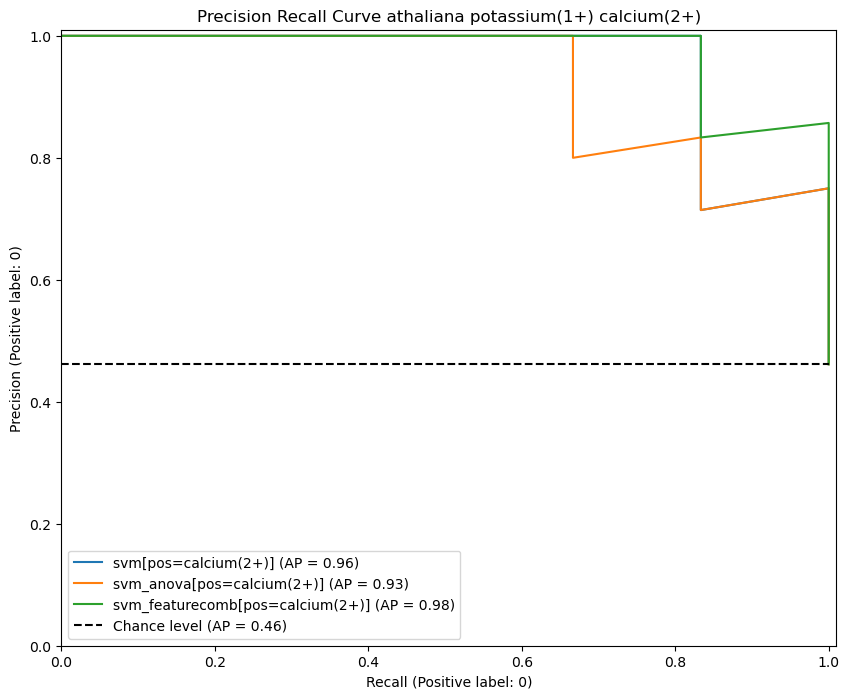

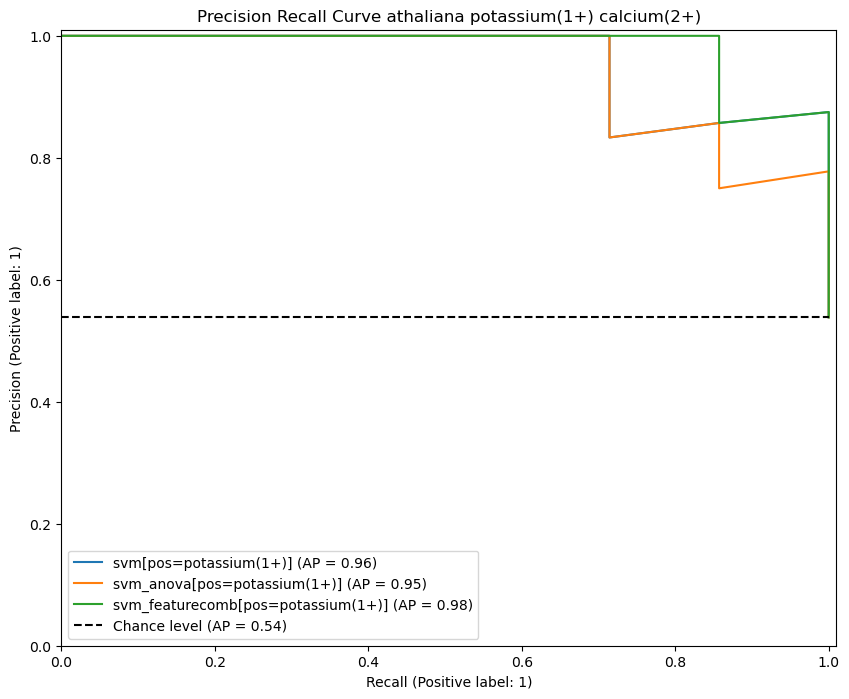

athaliana inorganic anion inorganic cation
cd-hit: clustered 312 sequences into 199 clusters at threshold 70
Proteins before removing non-transporters
 label
inorganic cation    158
inorganic anion      41
Name: count, dtype: int64
Proteins after removing non-transporters
 label
inorganic cation    153
inorganic anion      41
Name: count, dtype: int64
training model svm
Best training CV score 0.912



,precision,recall,f1-score,n_samples
inorganic anion (0),0.833,0.625,0.714,8
inorganic cation (1),0.909,0.968,0.937,31
accuracy,0.897,0.897,0.897,0
macro avg,0.871,0.796,0.826,39
weighted avg,0.894,0.897,0.892,39


training model svm_anova
Best training CV score 0.918



,precision,recall,f1-score,n_samples
inorganic anion (0),0.750,0.750,0.750,8
inorganic cation (1),0.935,0.935,0.935,31
accuracy,0.897,0.897,0.897,0
macro avg,0.843,0.843,0.843,39
weighted avg,0.897,0.897,0.897,39


training model svm_featurecomb


KeyboardInterrupt: 

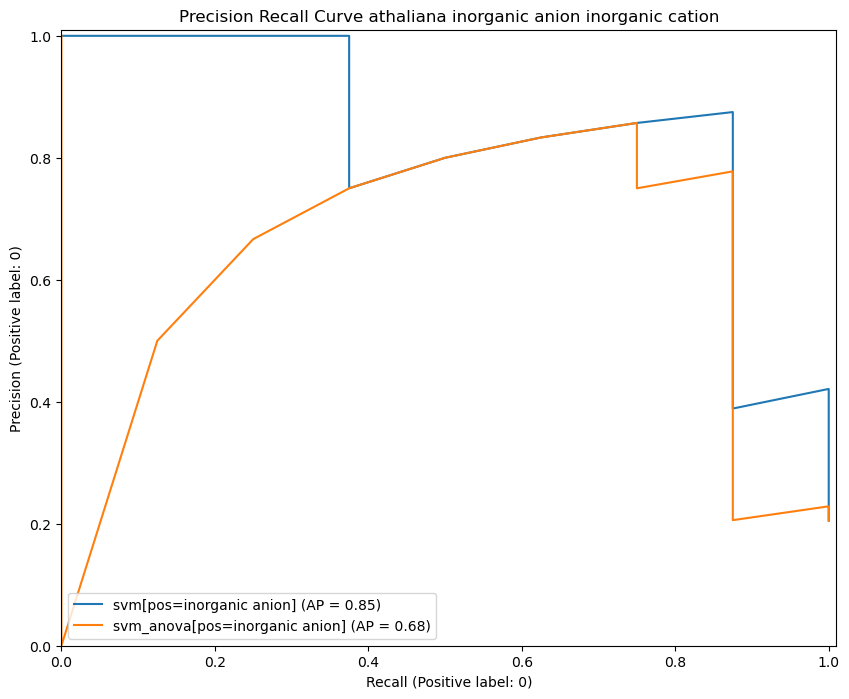

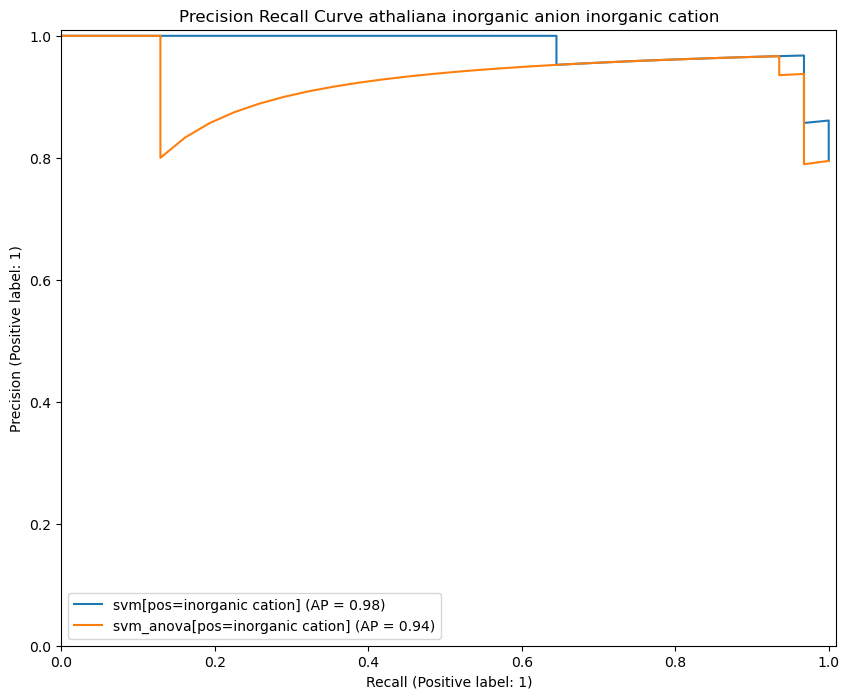

In [15]:
labels = {"potassium(1+)", "calcium(2+)"}

dataset_name_to_organism_ids = {
    "human": {9606},
    "athaliana": {3702},
    "ecoli": {83333},
    "yeast": {559292},
}
dataset_name_to_organism_ids["all"] = {
    list(s)[0] for s in dataset_name_to_organism_ids.values() if len(s) == 1
}

test_cases = [
    ("athaliana", "potassium(1+)", "calcium(2+)"),
    ("athaliana", "inorganic anion", "inorganic cation"),
    ("athaliana", "carboxylic acid anion", "inorganic anion"),
    ("ecoli", "carbohydrate derivative", "monosaccharide"),
    ("ecoli", "monocarboxylic acid", "amino acid"),
    ("human", "calcium(2+)", "sodium(1+)"),
    ("human", "calcium(2+)", "potassium(1+)"),
    ("human", "sodium(1+)", "potassium(1+)"),
    ("human", "inorganic anion", "inorganic cation"),
    ("yeast", "amide", "amino acid derivative"),
]
for dataset_name, substrate1, substrate2 in test_cases:
    print("=" * 60)
    print(dataset_name, substrate1, substrate2)
    print("=" * 60)
    organism_ids = dataset_name_to_organism_ids[dataset_name]
    df_dataset = get_classification_task(
        organism_ids=organism_ids,
        labels={substrate1, substrate2},
        clustering_threshold=70,
        include_ancestor_chebi_ids=True,
    )

    print(
        "Proteins before removing non-transporters\n", df_dataset.label.value_counts()
    )
    # TODO this is a quickfix, redo pipeline
    tmtp_proteins = get_goa_subset(
        root_term_name="transmembrane transporter activity",
        qualifiers_filter=["enables"],
        aspects_filter=["F"],
        proteins_filter=df_dataset.index.tolist(),
    ).Uniprot.unique()
    df_dataset = df_dataset[df_dataset.index.isin(set(tmtp_proteins))]
    print("Proteins after removing non-transporters\n", df_dataset.label.value_counts())
    # TODO quickfix end

    df_features = get_features(df_dataset.sequence)
    df_features = df_features.loc[df_features.index.sort_values()]
    df_dataset = df_dataset.loc[df_features.index]
    df_features = df_features.loc[df_dataset.index]
    (
        X_train,
        X_eval,
        y_train,
        y_eval,
        sample_names_train,
        sample_names_eval,
        feature_names,
        class_labels,
    ) = get_xy(df_dataset=df_dataset, df_features=df_features)

    # for roc curves
    fig_pr0, ax_pr0 = plt.subplots(figsize=(10, 8))
    ax_pr0.set_title(f"Precision Recall Curve {dataset_name} {substrate1} vs. {substrate2}")
    ax_pr0.set_xlim(0.0, 1.01)
    ax_pr0.set_ylim(0.0, 1.01)

    fig_pr1, ax_pr1 = plt.subplots(figsize=(10, 8))
    ax_pr1.set_title(f"Precision Recall Curve {dataset_name} {substrate1} vs. {substrate2}")
    ax_pr1.set_xlim(0.0, 1.01)
    ax_pr1.set_ylim(0.0, 1.01)
    # fig_roc, ax_roc = plt.subplots(figsize=(12, 10))
    # ax_roc.set_title(f"ROC Curve {dataset_name} {substrate1} {substrate2}")

    # model_names = ["svm"]
    model_names = ["svm", "svm_anova", "svm_featurecomb", "svm_featurecomb_anova"]
    model_names = ["svm", "svm_anova", "svm_featurecomb"]
    for model_name in model_names:
        print("training model", model_name)

        model = get_model(
            X_train=X_train,
            y_train=y_train,
            feature_names=feature_names,
            type=model_name,
        )
        df_cv_results = pd.DataFrame.from_dict(model.cv_results_)

        print("Best training CV score", round(model.best_score_, 3))

        PrecisionRecallDisplay.from_estimator(
            model.best_estimator_,
            X_eval,
            y_eval,
            ax=ax_pr0,
            name=model_name + f"[pos={class_labels[0]}]",
            pos_label=0,
            drawstyle="default" , # TODO interpolation
            plot_chance_level=model_name == model_names[-1]
        )
        PrecisionRecallDisplay.from_estimator(
            model.best_estimator_,
            X_eval,
            y_eval,
            ax=ax_pr1,
            name=model_name + f"[pos={class_labels[1]}]",
            pos_label=1,
            drawstyle="default",  # TODO interpolation parameter
            plot_chance_level=model_name == model_names[-1]
        )
        # TODO confusion matrix

        # independent test set
        eval_results = eval(X_eval=X_eval, y_eval=y_eval, model=model.best_estimator_)
        print()# TODO
        df_eval_results = pd.DataFrame.from_dict(eval_results).T.round(3)
        df_eval_results["support"] = df_eval_results.support.astype(int)
        class_to_classlabel = {
            str(number): label + f" ({number})"
            for number, label in enumerate(class_labels)
        }
        df_eval_results = df_eval_results.rename(index=class_to_classlabel)

        df_eval_results = df_eval_results.rename(columns={"support": "n_samples"})
        display(df_eval_results)  # TODO remove some rows and cols

    # ax_pr.set_ylabel("Precision")
    # ax_pr.set_xlabel("Recall")
    # ax_roc.set_ylabel("True Positive Rate")
    # ax_roc.set_xlabel("False Positive Rate")
    plt.show()


## Comparisons

Compare training results with: 

- Average sequence similarity
  - blast
- GO term similarity
  - How many protein in common?
  - Semantic similarity?
- CHebi similarity 
  - Smiles
- Annotation overlap